In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import copy
from sklearn.model_selection import train_test_split
import torchvision
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-1-bc4a5a901d40>:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
emnistData= torchvision.datasets.EMNIST(root='emnist',split='letters',download=True)
# split = 'letters' will choose letters only from this dataset it also contains numbers


100%|██████████| 561753746/561753746 [00:15<00:00, 36458300.04it/s]


Extracting emnist/EMNIST/raw/gzip.zip to emnist/EMNIST/raw


In [4]:
print(emnistData.classes)
print(type(emnistData.classes))
print(type(emnistData.data))
print(emnistData.data.shape)
print(emnistData.data)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
<class 'list'>
<class 'torch.Tensor'>
torch.Size([124800, 28, 28])
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]

In [5]:
print(emnistData.data.dtype)
images=emnistData.data.view([-1,1,28,28]).float()
images.dtype

torch.uint8


torch.float32

In [6]:
emnistData.class_to_idx
# we want to remove the N/A

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [7]:
letterCategories = emnistData.classes[1:]
labels = copy.deepcopy(emnistData.targets)-1
print(torch.sum(labels==0))
print(torch.sum(emnistData.targets==0))

tensor(4800)
tensor(0)


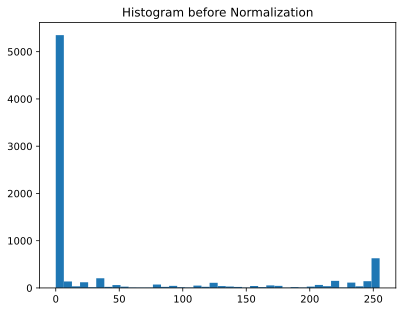

In [8]:
# visualization plt.hist takes a dimention full of values to show the freq of each value i took first 10 data items since it will be 10*28*28 and the 2nd parameter is 40 bins

plt.hist(images[:10].view(-1),40)
plt.title('Histogram before Normalization')
plt.show()

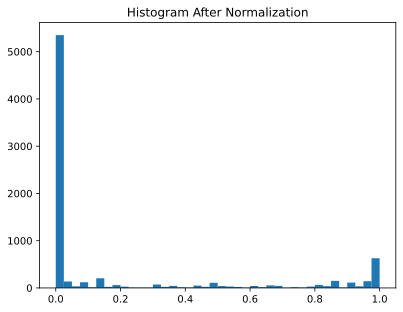

In [9]:
#Normalization
images/=torch.max(images)
# gets a the max value of all of the tensor values
plt.hist(images[:10].view(-1),40)
plt.title('Histogram After Normalization')
plt.show()

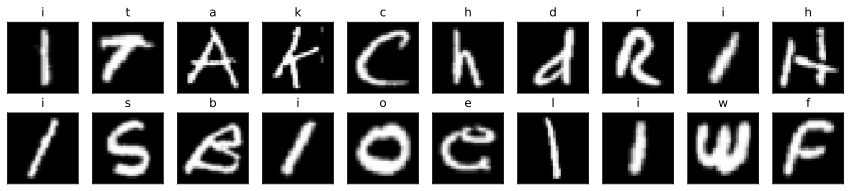

In [10]:
# visualze some letters of the dataset
fig, axs= plt.subplots(2,10,figsize=(15,3))
for i,ax in enumerate(axs.flatten()):
  randomIdx=np.random.choice(images.shape[0])
  randomImage=torch.squeeze(images[randomIdx])
  ax.imshow(randomImage.T,cmap='gray')
  ax.set_title(letterCategories[labels[randomIdx].item()])
  ax.set_xticks([])
  ax.set_yticks([])
plt.show()

In [11]:
# train loader and test loader for minibatches


train_data,test_data,train_labels,test_labels=train_test_split(images,labels,test_size=.1)

train_dataset=TensorDataset(train_data,train_labels)
test_dataset=TensorDataset(test_data,test_labels)


train_loader=DataLoader(train_dataset,shuffle=True,drop_last=True,batch_size=32)
test_loader=DataLoader(train_dataset,batch_size=test_dataset.tensors[0].shape[0])


In [12]:
# check size (should be N X i/p channels X width X height
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

torch.Size([112320, 1, 28, 28])
torch.Size([112320])


In [13]:
# create a class for the model
def createModelNet(printtoggle=False):

  class emnistCNN_Net(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      self.print = printtoggle

      self.conv1  = nn.Conv2d(1,6,3,padding=1)
      # input the number of channels in this layer
      self.bnorm1 = nn.BatchNorm2d(6)
      # output size: (28+2*1-3)/1 + 1 = 28/2 = 14 (div by 2 maxpool)

      self.conv2  = nn.Conv2d(6,6,3,padding=1)
       # input the number of channels in this layer
      self.bnorm2 = nn.BatchNorm2d(6)
      # output size: (14+2*1-3)/1 + 1 = 14/2 = 7 (div by 2 maxpool)


      self.fc1 = nn.Linear(7*7*6,50)
      self.fc2 = nn.Linear(50,26)

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'First CPR block: {list(x.shape)}')

      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      if self.print: print(f'Second CPR block: {list(x.shape)}')
      #if 32 minibatch => 32 x 6 x W x H
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      # -1 will be replaced by the unknown dimention in this case 32
      if self.print: print(f'Vectorized: {list(x.shape)}')

      x = F.leaky_relu(self.fc1(x))
      x = self.fc2(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  net =  emnistCNN_Net(printtoggle)

  lossfun = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [14]:
def fnToTrain():


  numEpochs=10
  net,lossfun,optimizer=createModelNet()
  testLosses=[]
  trainLosses=[]
  trainError=[]
  testError=[]
  net.to(device)
  for i in range(numEpochs):
    trainLossesEpoch=[]

    totalEpochTrainError=[]
    totalEpochTestError=[]
    for X,y in train_loader:

      X=X.to(device)
      y=y.to(device)
      #x shape 32 1 28 28 output will be 32 by 26
      yHat = net(X)
      # output will be logits of each class (minibatch * 26 ) dim = 1 is the dimention with the logits/score of each letter
      choosenIdx = torch.argmax(yHat,dim=1)
      # shape is now 32*1
      errorRateSingleEpoch = 100 * torch.mean((y!=choosenIdx).float())
      totalEpochTrainError.append(errorRateSingleEpoch.item())

      loss = lossfun(yHat,y)
      trainLossesEpoch.append(loss.item())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    trainLosses.append(np.mean(trainLossesEpoch))
    trainError.append(torch.mean(torch.Tensor(totalEpochTrainError)))
    net.eval()
    # sets the self.training to false

    X,y=next(iter(test_loader))


    X=X.to(device)
    y=y.to(device)
    with torch.no_grad():
      yHat = net(X)
      loss = lossfun(yHat,y)
    choosenIdx = torch.argmax(yHat,dim=1)
    testLosses.append(loss.item())
    errorRateTestEpoch = 100 * torch.mean((y!=choosenIdx).float())
    totalEpochTestError.append(errorRateTestEpoch.item())
    testError.append(torch.mean(torch.Tensor(totalEpochTestError)))
  return testLosses,trainLosses,trainError,testError,net




In [15]:
testLosses,trainLosses,trainError,testError,net= fnToTrain()

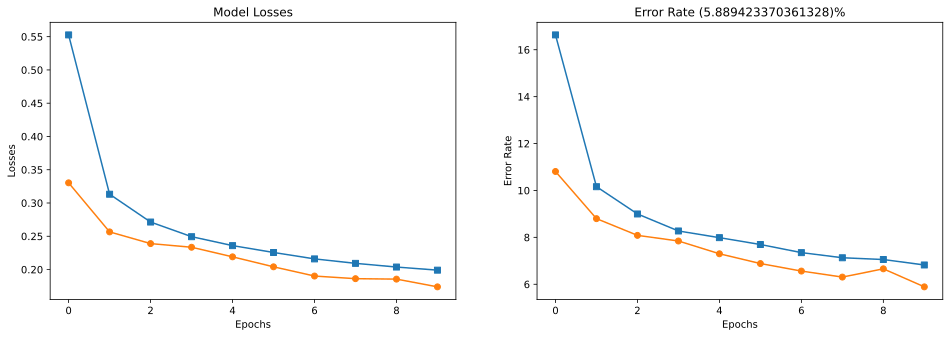

In [16]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].set_title('Model Losses')
ax[0].plot(trainLosses,'s-',label='train')
ax[0].plot(testLosses,'o-',label='test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Losses')


ax[1].set_title(f'Error Rate ({testError[-1]})%')
ax[1].plot(trainError,'s-',label='train')
ax[1].plot(testError,'o-',label='test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error Rate')
plt.show()

torch.Size([12480, 26])
(28,)
torch.Size([28])


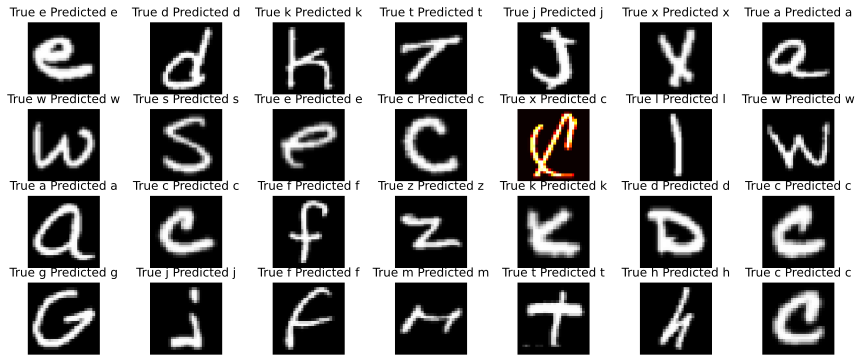

In [45]:


X,y  = next(iter(test_loader))
X=X.to(device)
y=y.to(device)
randomIdxImages= np.random.choice(len(y),size=7*4,replace=False)
# inputImages = images[randomIdxImages].to(device)
yHat= net(X)

selectedImages = X[randomIdxImages,0].cpu()
# print(yHat)
print(yHat.shape)
# print(randomIdxImages)
print(randomIdxImages.shape)
yHat2=yHat[randomIdxImages]
predictedLettersIndexes=  torch.argmax(yHat2,dim=1)
trueLetterIndexes = y[randomIdxImages]
print(predictedLettersIndexes.shape)

fig,axs=plt.subplots( 4,7,  figsize= (15,6))
for i,ax in enumerate(axs.flatten()):
  trueLetter = letterCategories[trueLetterIndexes[i]]
  predictedLetter = letterCategories[predictedLettersIndexes[i]]
  ax.set_title(f'True {trueLetter} Predicted {predictedLetter}')

  color = 'gray' if trueLetter==predictedLetter else 'hot'
  ax.imshow(selectedImages[i].T,cmap=color)
  ax.axis('off')
plt.show()

In [19]:
len(y)

12480

In [20]:
y.shape

torch.Size([12480])